In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

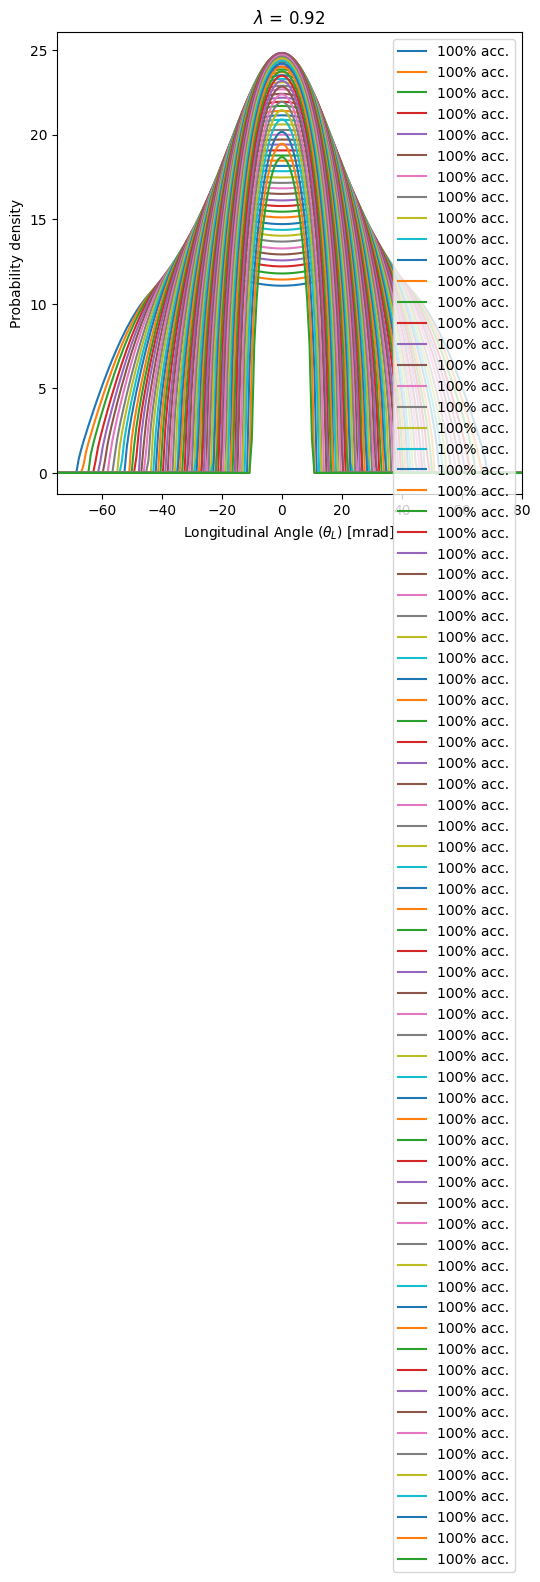

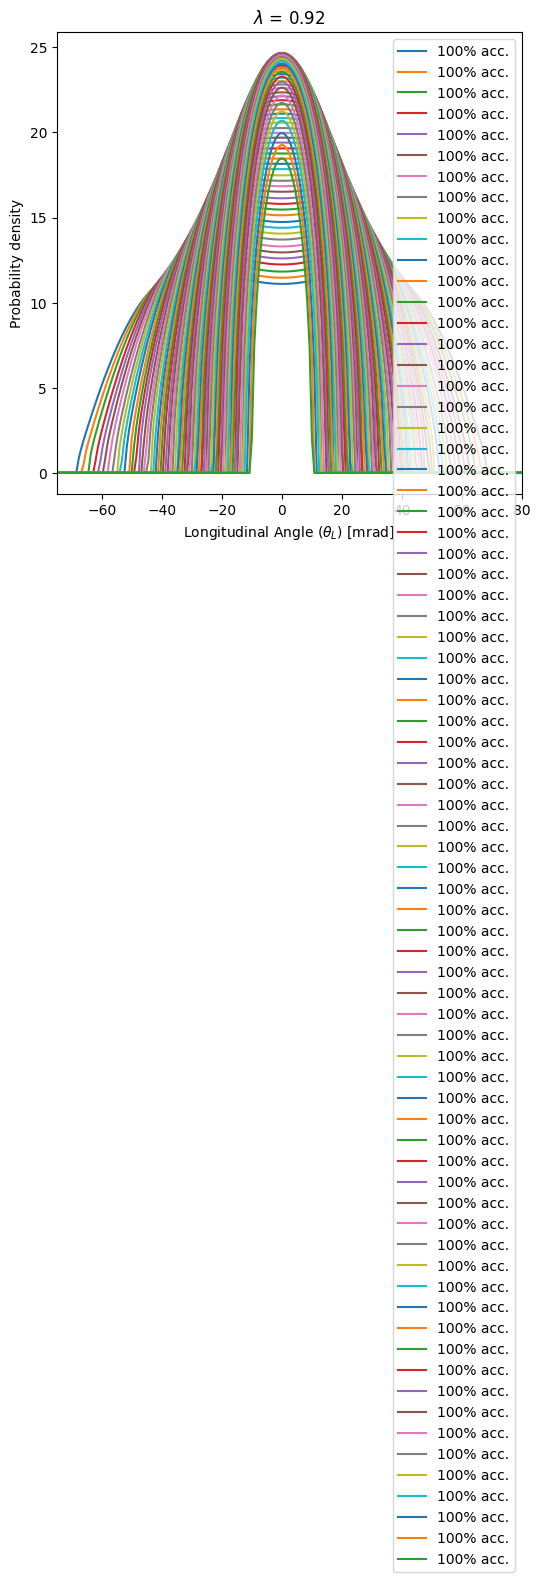

In [ ]:
# Load the without EDM data in

sliceLs = [0.2 + i*(0.01) for i in range(0,73)]

for i in range(2):
    filename=f"data/Without EDM/G2_{i:02}.pkl"
    plt.figure(figsize=(6,6))
    with open(filename, "rb") as f:
        """
        X: the fractional (i.e. divided by maximum energy) lab frame energy of the decay positrons: labelled as lambda: unitless
        Y: the lonitidunal angle of the decay positrons: labelled as theta_L: in mrad
        Z: the probability density of this lambda and tehta_L : unitless
        """
        X,Y,Z = pickle.load(f)
        l = X[0]
        theta = Y[:,0]
        
        for sliceL in sliceLs:
            lindex = np.argmin(np.abs(sliceL-l))
            z = Z[:,lindex].transpose()
            
            plt.xlim([-75, 80])
            plt.title(rf"$\lambda$ = {sliceL:.2f}")
            plt.plot(theta*1000, z, label="100% acc.")
            plt.xlabel(r"Longitudinal Angle ($\theta_{L}$) [mrad]")
            plt.ylabel("Probability density")
            plt.legend()
    plt.savefig(f"outputs/{filename[5:-4]}.png")
    plt.show()
    